# Bayesian Learning Lab3

Author : Yunan Dong, Yifan Ding

In [57]:
import math
import stan
import nest_asyncio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity

# config event loop for stan in juypyter
nest_asyncio.apply()

## Q1

### a)

In [58]:
with open('rainfall.dat') as f:
    doc = f.readlines()
    for i,j in enumerate(doc):
        doc[i] = int(j.split('\n')[0])
y = np.array(doc)
logy = np.log(y)

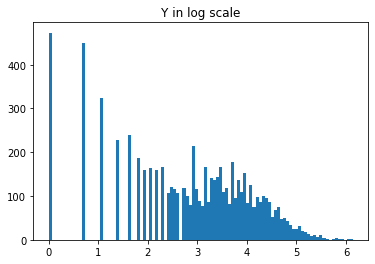

In [59]:
# prior parameters
mu0 = np.mean(logy)
tau0_squa = 1
v0 = 4
sigma0_squa = 1

mu = np.random.normal(mu0, np.sqrt(tau0_squa))
sigma_squa = sigma0_squa * v0 / np.random.chisquare(v0, size=1)

plt.hist(logy, bins=100)
plt.title('Y in log scale')
plt.show()

In [60]:
steps = 1000
chains = 4
n = len(logy)

chain_collection = []
for i in range(chains):
    mu_collection = []
    sigma_collection = []
    for i in range(steps):

        # update mu
        epsilon = n / sigma_squa
        w = (epsilon) / (epsilon + 1 / tau0_squa)
        mu_n = w * np.mean(logy) + (1 - w) * mu0
        tau_n_squa = 1 / (epsilon + 1 / tau0_squa)
        mu = np.random.normal(mu_n, np.sqrt(tau_n_squa))

        # update sigma
        vn = v0 + n
        sigma_squa_scale = (v0 * sigma0_squa + np.sum((logy - mu)**2)) / vn
        sigma_squa = sigma_squa_scale * vn / np.random.chisquare(vn, size=1)

        mu_collection.append(mu)
        sigma_collection.append(sigma_squa)

    mu_collection = np.array(mu_collection)
    sigma_collection = np.array(sigma_collection)
    theta_collection = np.concatenate([mu_collection, sigma_collection], axis=1)
    chain_collection.append(theta_collection)
chain_collection = np.array(chain_collection)

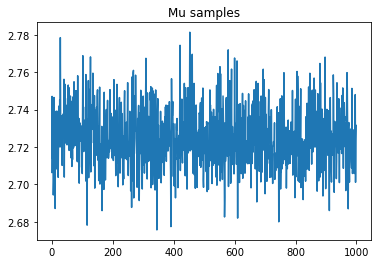

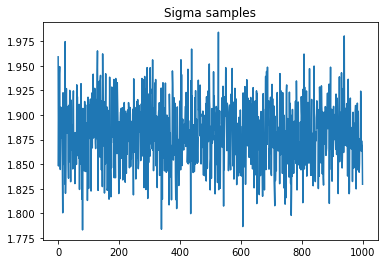

In [61]:
plt.figure()
plt.plot(mu_collection)
plt.title('Mu samples')
plt.show()

plt.figure()
plt.plot(sigma_collection)
plt.title('Sigma samples')
plt.show()

Our Ineffeciency Factor fuction was modified from Pymc's official code of ESS(Effective sample size), the official code is [here](https://github.com/pymc-devs/pymc/blob/14d8e9fc03bf9be1c3508b8b4563561480f0b358/pymc/diagnostics.py#L497)

In [62]:
def ineffeciency_factor(x):
    """ Returns estimate of the effective sample size of a set of traces.
    Parameters
    ----------
    x : array-like
      An array containing the 2 or more traces of a stochastic parameter. That is, an array of dimension m x n x k, where m is the number of traces, n the number of samples, and k the dimension of the stochastic.
    
    Returns
    -------
    n_eff : float
      Return the effective sample size, :math:`\hat{n}_{eff}`
    Notes
    -----
    The diagnostic is computed by:
      .. math:: \hat{n}_{eff} = \frac{mn}}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}
    where :math:`\hat{\rho}_t` is the estimated autocorrelation at lag t, and T
    is the first odd positive integer for which the sum :math:`\hat{\rho}_{T+1} + \hat{\rho}_{T+1}` 
    is negative.
    References
    ----------
    Gelman et al. (2014)"""
    
    if np.shape(x) < (2,):
        raise ValueError(
           'Calculation of effective sample size requires multiple chains of the same length.')

    try:
        m, n = np.shape(x)
    except ValueError:
        return [effective_n(np.transpose(y)) for y in np.transpose(x)]
        
    s2 = gelman_rubin(x, return_var=True)
    
    negative_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t])**2 for i in range(t,n)) for j in range(m)) 
                                / (m*(n - t)))
    rho = np.ones(n)
    # Iterate until the sum of consecutive estimates of autocorrelation is negative
    while not negative_autocorr and (t < n):
        
        rho[t] = 1. - variogram(t)/(2.*s2)
        
        if not t % 2:
            negative_autocorr = sum(rho[t-1:t+1]) < 0
        
        t += 1
        
    return 1 + 2*rho[1:t].sum()



def gelman_rubin(x, return_var=False):
    """ Returns estimate of R for a set of traces.
    The Gelman-Rubin diagnostic tests for lack of convergence by comparing
    the variance between multiple chains to the variance within each chain.
    If convergence has been achieved, the between-chain and within-chain
    variances should be identical. To be most effective in detecting evidence
    for nonconvergence, each chain should have been initialized to starting
    values that are dispersed relative to the target distribution.
    Parameters
    ----------
    x : array-like
      An array containing the 2 or more traces of a stochastic parameter. That is, an array of dimension m x n x k, where m is the number of traces, n the number of samples, and k the dimension of the stochastic.
      
    return_var : bool
      Flag for returning the marginal posterior variance instead of R-hat (defaults of False).
    Returns
    -------
    Rhat : float
      Return the potential scale reduction factor, :math:`\hat{R}`
    Notes
    -----
    The diagnostic is computed by:
      .. math:: \hat{R} = \sqrt{\frac{\hat{V}}{W}}
    where :math:`W` is the within-chain variance and :math:`\hat{V}` is
    the posterior variance estimate for the pooled traces. This is the
    potential scale reduction factor, which converges to unity when each
    of the traces is a sample from the target posterior. Values greater
    than one indicate that one or more chains have not yet converged.
    References
    ----------
    Brooks and Gelman (1998)
    Gelman and Rubin (1992)"""

    if np.shape(x) < (2,):
        raise ValueError(
           'Gelman-Rubin diagnostic requires multiple chains of the same length.')

    try:
        m, n = np.shape(x)
    except ValueError:
        return [gelman_rubin(np.transpose(y)) for y in np.transpose(x)]

    # Calculate between-chain variance
    B_over_n = np.sum((np.mean(x, 1) - np.mean(x)) ** 2) / (m - 1)

    # Calculate within-chain variances
    W = np.sum(
        [(x[i] - xbar) ** 2 for i,
         xbar in enumerate(np.mean(x,
                                   1))]) / (m * (n - 1))

    # (over) estimate of variance
    s2 = W * (n - 1) / n + B_over_n
    
    if return_var:
        return s2

    # Pooled posterior variance estimate
    V = s2 + B_over_n / m

    # Calculate PSRF
    R = V / W

    return np.sqrt(R)

In [63]:
ineffeciency_factor(chain_collection)

[0.9720755113768855, 0.9479616113805689]

IF-values near 1 therefore suggest this is a very effcient sampler.

### b)

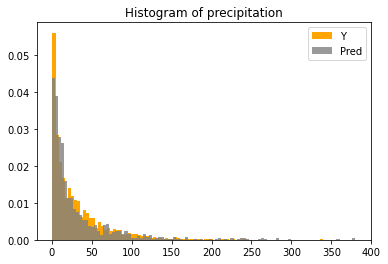

In [64]:
predict = np.random.normal(mu_collection, np.sqrt(sigma_collection))
predict = np.exp(predict)

plt.figure()
plt.hist(y[y<400], bins=100, density=True, color='orange', label='Y')
plt.hist(predict[predict<400], bins=100, density=True, color='gray',  label='Pred', alpha=0.8)
plt.title('Histogram of precipitation')
plt.legend()
plt.show()

Answer: the prediction results matched original data very well except the region close to 0, where original data more dense than predicted results.

## Q2

### a)

In [65]:
with open('eBayNumberOfBidderData.dat') as f:
    doc = f.readlines()    
    doc = doc[1:]
    for i in range(len(doc)):
        doc[i] = np.array(doc[i].split()).astype(np.float)
        
doc = np.array(doc)
Y = doc[:, :1]
X = doc[:, 1:]

The likelihood of poisson regression

$$lik= \prod_{i=1}^n \frac{e^{y_i\beta^Tx_i - e^{\beta^T x_i}}}{y_i!}$$

Then minus log likelihood:

$$-loglik  =  -\sum_{i=1}^n y_i\beta^Tx_i - e^{\beta^Tx_i} - log(y_i!) = - Y^T X\beta + \sum e^{X\beta} $$

Note that $-log(y_i!)$ has nothing to do with $\beta$, thus eliminated.

$$\frac{\partial(-loglik)}{\partial \beta} = - X^T Y + X^T e^{X \beta}$$



In [66]:
# minus log likelihood
def poisson_lik(X, Y, beta):
    minusloglik = - Y.T @ X @ beta + np.sum(np.exp(X @ beta))
    return minusloglik

# gradiant of minus log likelihood
def grad_loglikli(X, Y, beta):
    grad_loglikli = - X.T @ Y + X.T @ np.exp(X @ beta)
    return grad_loglikli

# numeric optimization
def update_beta(betas, lr, grad, hessian=None):
    # Newton method
    if hessian:
        betas = betas -  lr * np.linalg.inv(hessian) @ grad
    # Gradiant descent
    else:
        betas = betas -  lr * grad
    return betas

In [67]:
betas = np.ones([X.shape[1], 1])
lr = 1e-4
iterations = 1000

for i in range(iterations):
    minuslog_like = poisson_lik(X, Y, betas)
    grad = grad_loglikli(X, Y, betas)
    # hess = hessian(betas, sigma, X)
    betas = update_beta(betas, lr, grad)
print(betas)

[[ 1.07244139]
 [-0.02054088]
 [-0.3945106 ]
 [ 0.44384269]
 [-0.05219768]
 [-0.22086194]
 [ 0.07067357]
 [-0.12067802]
 [-1.89409689]]


### b)

Minus log prior, first and second order derivatives:

$$ -logp(\beta) = \frac{1}{2}(\beta - \mu)^T \Sigma^{-1} (\beta - \mu)$$

$$\frac{\partial (-logp(\beta))}{\partial \beta} = \Sigma^{-1} (\beta - \mu)$$

$$ \frac{\partial ^2 (-logp(\beta))}{\partial \beta \partial \beta^T}  = \Sigma^{-1}$$ 

Where $\mu =0$ and $\Sigma = 100  (X^T X) ^{-1}$, constant of $-logp(\beta)$ has been eliminated.


Minus log likelihood(copied from section a)), first and second order derivatives:

$$-loglik = - Y^T X\beta + \sum e^{X\beta} $$

$$\frac{\partial(-loglik)}{\partial \beta} = - X^T Y + X^T e^{X \beta}$$

$$ \frac{\partial ^2 (-loglik)}{\partial \beta \partial \beta^T} = X^T (e^{X\beta} .* X)$$

Where $.*$ is element wise product, therefore, over all posterior, Jacobian and Hessian:

$$-logp(\beta|X,Y) = \frac{1}{2}(\beta - \mu)^T \Sigma^{-1} (\beta - \mu) - Y^T X\beta + \sum e^{X\beta}$$

$$ J = \Sigma^{-1} (\beta - \mu) - X^T Y + X^T e^{X \beta}$$

$$ H = \Sigma^{-1} + X^T (e^{X\beta} .* X)$$

In [68]:
# minus log posterior
def logpoisson_posterior(X, Y, beta, sigma, mu):
    minusloglik = - Y.T @ X @ beta + np.sum(np.exp(X @ beta))
    minprior = 1/2 * (beta - mu).T @ np.linalg.inv(sigma) @ (beta - mu)
    return minusloglik + minprior

# gradiant of minus log posterior
def grad_posterior(X, Y, beta, sigma, mu):
    grad_loglikli = - X.T @ Y + X.T @ np.exp(X @ beta)
    grad_prior = np.linalg.inv(sigma) @ (beta - mu)
    return grad_loglikli + grad_prior

# hessian of minus log posterior
def hessian_posterior(X, beta, sigma):
    H = np.linalg.inv(sigma) + X.T @ (np.exp(X @ beta) * X)
    return H

In [69]:
betas = np.ones([X.shape[1], 1])
mu = np.zeros(betas.shape)
sigma = 100 * np.linalg.inv(X.T @ X)
lr = 1e-4
iterations = 1000

for i in range(iterations):
    posterior = logpoisson_posterior(X, Y, betas, sigma, mu)
    grad = grad_posterior(X, Y, betas, sigma, mu)
    hess = hessian_posterior(X, betas, sigma,)
    betas = update_beta(betas, lr, grad)
print(betas)

[[ 1.06984173]
 [-0.02051352]
 [-0.39300269]
 [ 0.44355685]
 [-0.05246213]
 [-0.2212297 ]
 [ 0.07070286]
 [-0.1202211 ]
 [-1.89198651]]


In [70]:
# Std
invhess = np.linalg.inv(hess)
np.sqrt(np.diag(invhess))

array([0.03074837, 0.03678417, 0.09227861, 0.05057447, 0.06020457,
       0.09146036, 0.05634756, 0.02895636, 0.07109679])

### c)

In [72]:
c = 1
sigma_RWM = invhess
# if using original MH rather than random walk
MH = False
#betas = np.ones([X.shape[1], 1])
sample_num = 1000

betas_collection = []
for i in range(sample_num):
    # propose new betas
    betas_p = np.random.multivariate_normal(betas.reshape(-1), c * sigma_RWM).reshape(-1, 1)
    u = np.random.uniform()
    
    # log posteriors
    post_proposal = logpoisson_posterior(X, Y, betas_p, sigma, mu)
    post_before = logpoisson_posterior(X, Y, betas, sigma, mu)
    
    # our posterior is already in minus-log scale
    accept_bound = np.exp(post_before - post_proposal)
    
    if MH:
        back_p = multivariate_normal.pdf(betas.reshape(-1), mean=betas_p.reshape(-1), cov=c * sigma_RWM)
        trans_p = multivariate_normal.pdf(betas_p.reshape(-1), mean=betas.reshape(-1), cov=c * sigma_RWM)
        accept_bound = accept_bound / trans_p * back_p
    
    alpha = np.min([1, accept_bound])
    
    # check the acceptance rate
    if u < alpha:
        betas = betas_p
    betas_collection.append(betas.reshape(-1))
    
betas_collection = np.array(betas_collection)

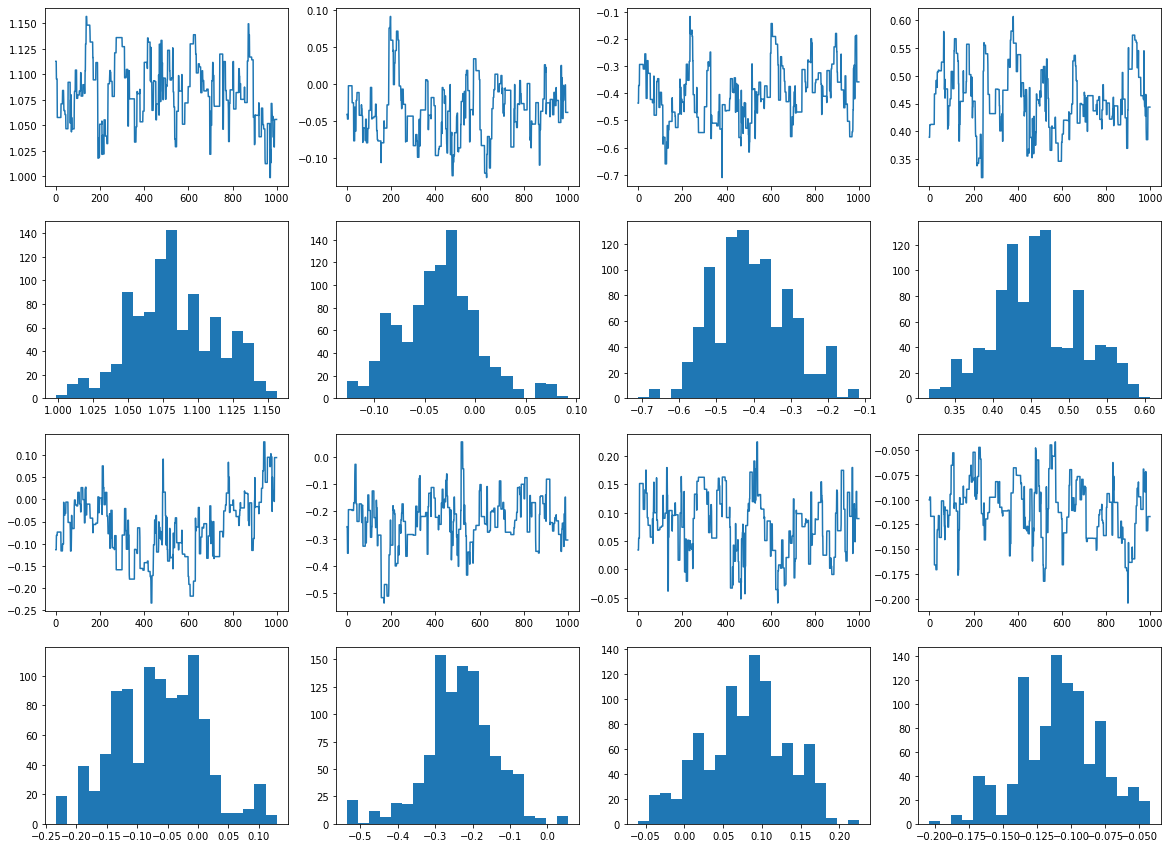

In [73]:
fig, axs = plt.subplots(4, 4,figsize=(20,15))

for i in range(4):
    axs[0, i].plot(betas_collection[:, i])
    axs[1, i].hist(betas_collection[:, i], bins=20)
    axs[2, i].plot(betas_collection[:, i + 4])
    axs[3, i].hist(betas_collection[:, i + 4], bins=20)
plt.show()

### d) 

No bidder :0.5560870690836389


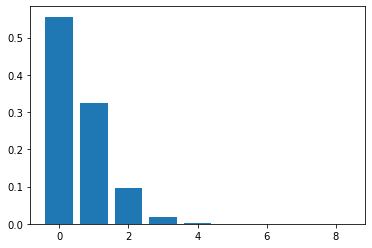

In [74]:
auction = np.array([1, 1, 1, 1, 0, 1, 0, 1, 0.7]).reshape(-1, 1)

def possion_reg(x, y, beta):
    prob_y = np.exp(y * beta @ x - np.exp(beta @ x)) / math.factorial(y)
    return np.mean(prob_y)

prob_0 = possion_reg(auction, 0, betas_collection)
print('No bidder :{}'.format(prob_0))


heights = []
for i in range(9):
    height = possion_reg(auction, i, betas_collection)
    heights.append(height)

plt.figure()
plt.bar(x=np.arange(9), height=heights)
plt.show()

# Q3

### a)

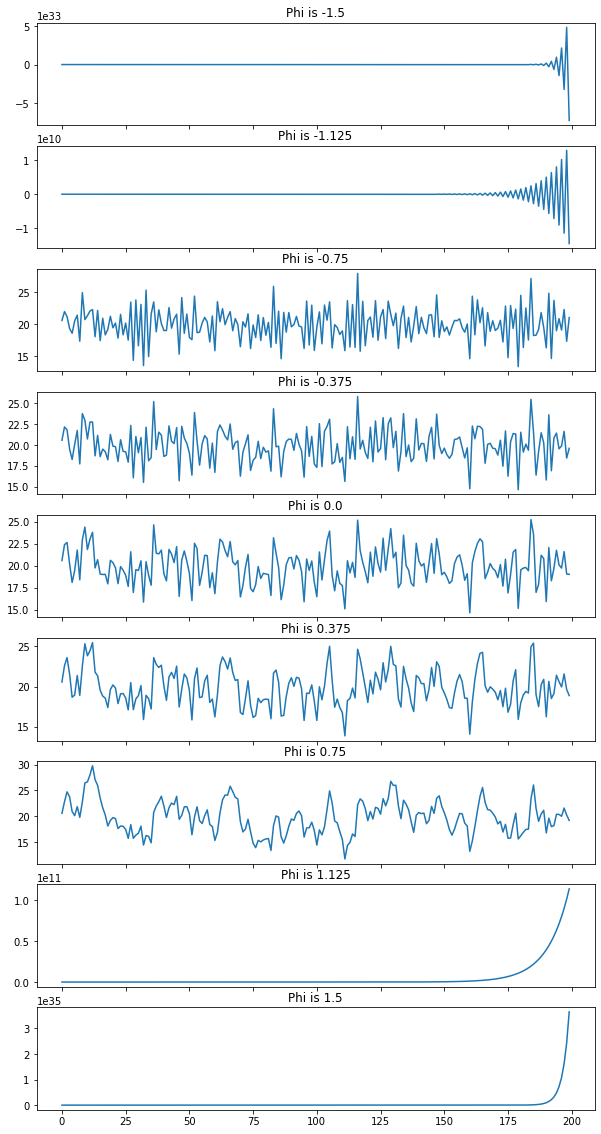

In [75]:
def get_autoreg(x, mu, sigma, phi, T):
    xs = []
    for i in range(T):
        x = mu + phi * (x - mu) + np.random.normal(0, np.sqrt(sigma))
        xs.append(x)
    
    return np.array(xs)

mu = 20
sigma_2 = 4
T = 200
x0 = mu
phi = np.linspace(-1.5, 1.5, 9)

xs = get_autoreg(x0, mu, sigma_2, phi, T)

fig, axs = plt.subplots(9,figsize=(10,20))
for i in range(9):
    axs[i].plot(xs[:, i])
    axs[i].set_title('Phi is {}'.format(phi[i]))
    axs[i].label_outer()

plt.show() 

AR(1) can generate higher frequency signal when Phi decreases between (-1, 1). When phi is outside of (-1, 1), the process becomes unstable.

### b)

#### i

In [76]:
AR_1 = """
data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  real mu;
  real phi;
  real<lower=0> sigma;
}

model {
  mu ~ normal(0,100);
  phi ~ normal(0,4);
  sigma ~ scaled_inv_chi_square(1,2);
    
  for (n in 2:N) {
    y[n] ~ normal(mu + phi * (y[n-1] - mu), sqrt(sigma));
  }
}
"""
phi_x = 0.3
phi_y = 0.9

data_x = {"y": get_autoreg(x0, mu, sigma_2, phi_x, T), "N": T}
data_y = {"y": get_autoreg(x0, mu, sigma_2, phi_y, T), "N": T}
init = {"mu": 0, "phi": 0, "sigma": 100}


posterior = stan.build(AR_1, data=data_x)
fit = posterior.sample(num_chains=1, num_samples=1000, init=[init])
df_x = fit.to_frame() 

posterior = stan.build(AR_1, data=data_y)
fit = posterior.sample(num_chains=1, num_samples=1000)
df_y = fit.to_frame() 

Building...



Building: found in cache, done.Messages from stanc:
Warning at '/var/folders/03/_k7872h17rvg940l_19p5sf40000gp/T/httpstan_bli7ltg0/model_wkpqdsfb.stan', line 13, column 16 to column 19:
  Argument 100 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling: 

Building...



Building: found in cache, done.Messages from stanc:
Warning at '/var/folders/03/_k7872h17rvg940l_19p5sf40000gp/T/httpstan_bli7ltg0/model_wkpqdsfb.stan', line 13, column 16 to column 19:
  Argument 100 suggests there may be parameters that are not unit scale;
  consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling:   0% (1/2000)
Sampling: 

In [77]:
def get_ci(df):
    eti_low = np.percentile(df, 2.5)
    eti_hight = np.percentile(df, 97.5)
    return [round(eti_low, 4), round(eti_hight, 4)]

def get_stats(df):
    
    ci_mu = get_ci(df['mu'])
    ci_phi = get_ci(df['phi'])
    ci_sigma = get_ci(df['sigma'])
    mean_mu = np.mean(df['mu'])
    mean_phi = np.mean(df['phi'])
    mean_sigma = np.mean(df['sigma'])
    d = {"mu":[ci_mu, mean_mu], "phi":[ci_phi, mean_phi], "sigma":[ci_sigma, mean_sigma]}
    stats = pd.DataFrame(data=d, index=['95 % CI', 'mean'])
    
    return stats

In [78]:
df_x.describe()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,phi,sigma
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,-228.714831,0.926683,7.104316e-01,2.397000,4.998000,0.0,230.235678,19.689371,0.289405,3.642192
std,1.330734,0.092019,1.121886e-14,0.554706,2.035716,0.0,1.853588,0.205268,0.072385,0.365328
min,-237.036540,0.387651,7.104316e-01,1.000000,1.000000,0.0,227.335711,18.952219,0.060243,2.619550
25%,-229.346417,0.896547,7.104316e-01,2.000000,3.000000,0.0,228.869221,19.563134,0.241992,3.376488
50%,-228.383700,0.960157,7.104316e-01,2.000000,7.000000,0.0,229.913038,19.684171,0.289717,3.615605
75%,-227.756611,0.994726,7.104316e-01,3.000000,7.000000,0.0,231.181507,19.834775,0.335038,3.882798
max,-227.122215,1.000000,7.104316e-01,3.000000,7.000000,0.0,239.393563,20.291169,0.524953,5.203352


In [79]:
get_stats(df_x)

,mu,phi,sigma
95 % CI,"[19.2678, 20.089]","[0.1445, 0.4275]","[3.0309, 4.4472]"
mean,19.6894,0.289405,3.64219


In [80]:
df_y.describe()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,phi,sigma
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,-227.130026,0.905253,4.744445e-01,2.526000,6.172000,0.0,228.656713,19.725970,0.934107,3.588954
std,1.371009,0.144176,5.553893e-15,0.556447,2.223367,0.0,1.851862,3.214392,0.030649,0.377928
min,-233.777173,0.012237,4.744445e-01,1.000000,1.000000,0.0,225.452567,4.348147,0.856732,2.536705
25%,-227.851944,0.886983,4.744445e-01,2.000000,5.000000,0.0,227.294239,18.194968,0.911710,3.314962
50%,-226.795288,0.955849,4.744445e-01,3.000000,7.000000,0.0,228.327613,19.643829,0.933419,3.568717
75%,-226.086098,0.989774,4.744445e-01,3.000000,7.000000,0.0,229.752130,21.102452,0.955362,3.832711
max,-225.390160,1.000000,4.744445e-01,4.000000,15.000000,0.0,237.681694,37.296016,1.019203,5.267277


In [81]:
get_stats(df_y)

,mu,phi,sigma
95 % CI,"[13.6912, 27.3167]","[0.8752, 0.9952]","[2.9403, 4.3611]"
mean,19.726,0.934107,3.58895


#### ii

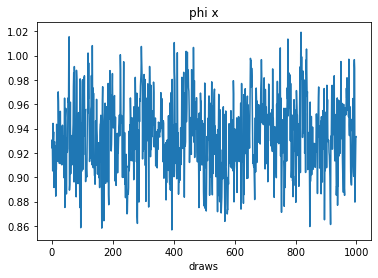

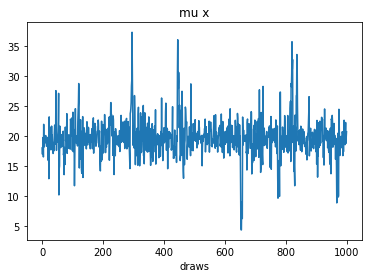

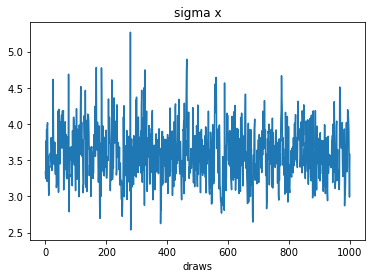

In [82]:
df_y['phi'].plot(title='phi x')
plt.show()
df_y['mu'].plot(title='mu x')
plt.show()
df_y['sigma'].plot(title='sigma x')
plt.show()

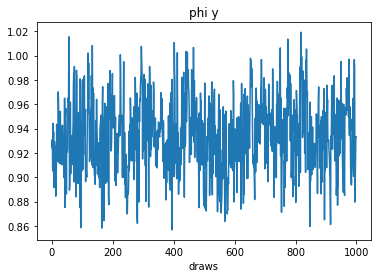

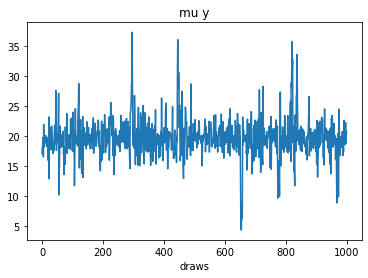

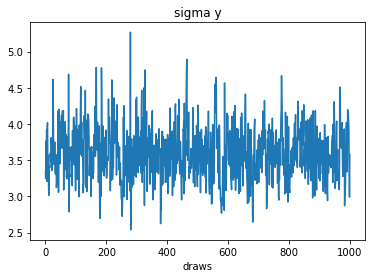

In [83]:
df_y['phi'].plot(title='phi y')
plt.show()
df_y['mu'].plot(title='mu y')
plt.show()
df_y['sigma'].plot(title='sigma y')
plt.show()

Analytically, joint distribution of $\Phi$ and $\mu$ suppose to be a 2-Dimentional Gaussian distribution, and the sampled joint distributions estimated by kernel density estimation are illustrated below.

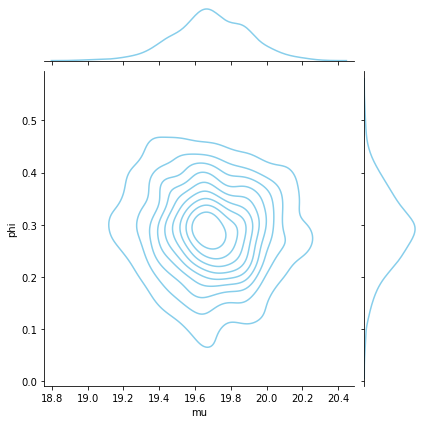

In [84]:
sns.jointplot(x=df_x["mu"], y=df_x["phi"], kind='kde', color="skyblue")
plt.show()

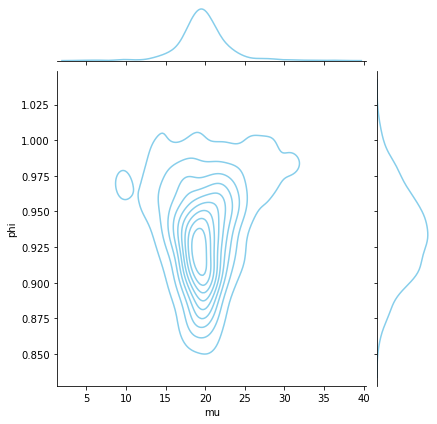

In [85]:
sns.jointplot(x=df_y["mu"], y=df_y["phi"], kind='kde', color="skyblue")
plt.show()